# Testing on simple O2-O2 toy model: DFT scan

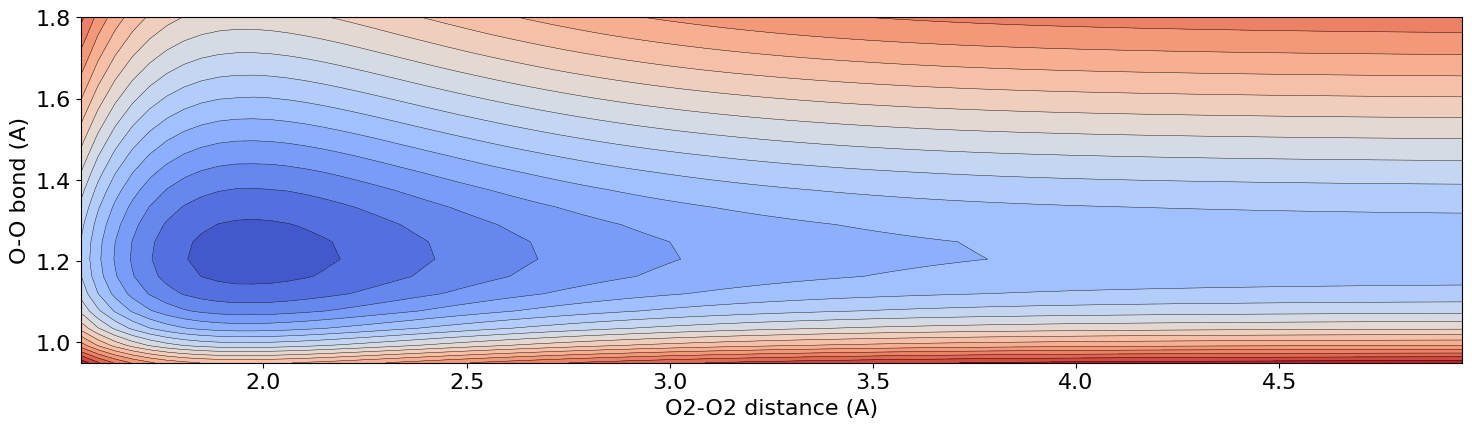

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import ase.io

plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['font.size'] = 16

def get_data(db, lb='energy'):
    eng = []
    r = []
    R = []
    for at in db:
        r += [at.positions[2,1]*2]
        R += [at.positions[0,0]]
        eng += [at.info[lb]]
    return np.array(r), np.array(R), np.array(eng)

def grid_data(db, lb='energy'):
    r, R, eng = get_data(db, lb)
    idx = np.arange(len(db))
    N = np.unique(R).shape[0]
    n = np.unique(r).shape[0]
    r2 = r.reshape(N,n).T
    R2 = R.reshape(N,n).T
    eng2 = eng.reshape(N,n).T
    idx2 = idx.reshape(N,n).T
    return r2, R2, eng2, idx2

def plot_data(r, R, eng, N=20, zlim=None):
    eng2 = eng.copy()
    if zlim:
        eng2[eng2<zlim[0]] = zlim[0]
        eng2[eng2>zlim[1]] = zlim[1]
    plt.contourf(R, r, eng2, N, cmap='coolwarm')
    plt.contour(R, r, eng2, N, colors='black', linestyles='solid', linewidths=0.3)
    plt.xlabel('O2-O2 distance (A)')
    plt.ylabel('O-O bond (A)')
    plt.xlim([np.min(R), np.max(R)])
    plt.ylim([np.min(r), np.max(r)])
    plt.gca().set_aspect("equal")
    plt.tight_layout()
    
    
db = ase.io.read('data/O4_2D_scan.xyz',':')
r2, R2, eng2, _ = grid_data(db, 'energy_smooth')

plot_data(r2, R2, eng2)
plt.show()

## Fit GAP models (Nmax=12)

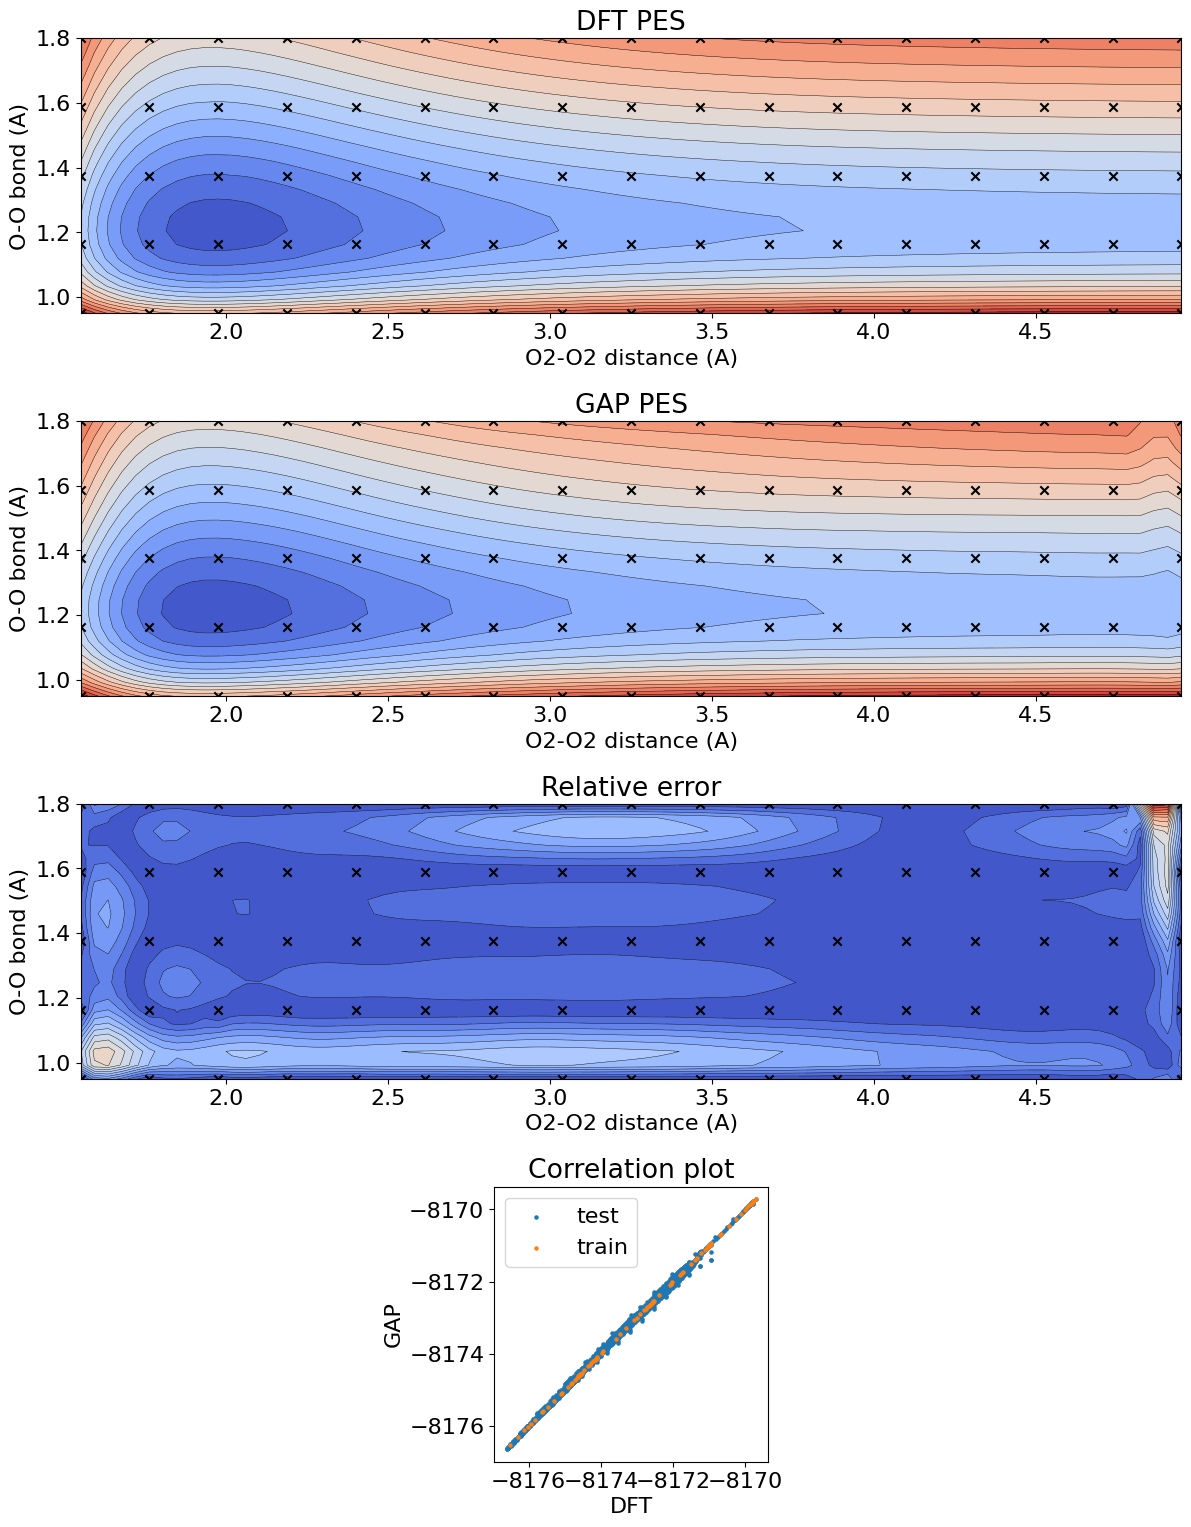

In [5]:
from quippy import descriptors

def calc_quip_descr(db, desc_str):
    ds = descriptors.Descriptor(desc_str)
    ps = ds.calc(db)
    return np.vstack([p['data'][:,:-1] for p in ps])

def calc_kernel(dat1, dat2, desc_str):
    ps1 = calc_quip_descr(dat1, desc_str)
    ps2 = calc_quip_descr(dat2, desc_str)
    K_atomic = np.matmul(ps1, ps2.T)**4
    K = np.add.reduceat(K_atomic, np.arange(0, K_atomic.shape[0], 4), axis=0)
    K = np.add.reduceat(K, np.arange(0, K.shape[1], 4), axis=1)
    return K

def train_model(dat, dft, S, desc_str):
    K = calc_kernel(dat, dat, desc_str)
    c,_,_,_ = np.linalg.lstsq(K+S, dft, rcond=None)
    return c

def pred_model(ref, c, dat, desc_str):
    K = calc_kernel(dat, ref, desc_str)
    gap = np.matmul(K, c)
    return gap

def calc_rmse(dat1, dat2):
    return np.sqrt(np.mean((dat1-dat2)**2))

def scan_regularization(db, eng, tdb, teng, sig_col):
    rmse_col = []
    for sig in sig_col:
        S = sig*np.eye(len(tdb))
        c = train_model(tdb, teng, S)
        peng = pred_model(tdb, c, db)
        rmse = calc_rmse(eng, peng)
        rmse_col += [rmse] 
    return np.array(rmse_col)

db = ase.io.read('data/O4_2D_scan.xyz',':')
_, _, eng = get_data(db, 'energy_smooth')
r2, R2, eng2, idx2 = grid_data(db, 'energy_smooth')
tdb = []
idx = idx2[::5,::5].T.flatten()
tdb = [db[i] for i in idx]
_, _, teng = get_data(tdb, 'energy_smooth')
tr2, tR2, teng2, _ = grid_data(tdb, 'energy_smooth')

sig = 1e-10
ds = "soap cutoff=6.0 cutoff_transition_width=1 n_max=12 l_max=6 atom_sigma=0.8 n_Z=1 Z={8} n_species=1 species_Z={8}"

S = sig*np.eye(len(tdb))
c = train_model(tdb, teng, S, ds)
peng = pred_model(tdb, c, db, ds)
pteng = pred_model(tdb, c, tdb, ds)
for i, at in enumerate(db):
    at.info['peng'] = peng[i]

_, _, peng2, _ = grid_data(db, 'peng')
plt.subplot(4,1,1)
plot_data(r2, R2, eng2)
plt.scatter(tR2, tr2, color='black', marker='x')
plt.title('DFT PES')
plt.subplot(4,1,2)
plot_data(r2, R2, peng2)
plt.scatter(tR2, tr2, color='black', marker='x')
plt.title('GAP PES')
plt.subplot(4,1,3)
plot_data(r2, R2, np.abs(peng2-eng2)/np.abs(eng2))
plt.scatter(tR2, tr2, color='black', marker='x')
plt.title('Relative error')
plt.subplot(4,1,4)
plt.scatter(eng, peng, s=5, label='test')
plt.scatter(teng, pteng, s=5, label='train')
plt.gca().set_aspect('equal')
plt.xlabel('DFT')
plt.ylabel('GAP')
plt.title('Correlation plot')
plt.legend()

## Boltzmann samples

In [8]:
from random import randrange, uniform

def choose_samples(eng, N, T=1.0):
    idx = []
    E0 = np.min(eng)
    prob = np.exp(-(eng-E0)/T)
    prob /= np.sum(prob)
    while len(idx)<N:
        i = randrange(len(eng))
        if not i in idx:
            p = uniform(0,1)
            if p <= prob[i]:
                idx += [i]
    return idx

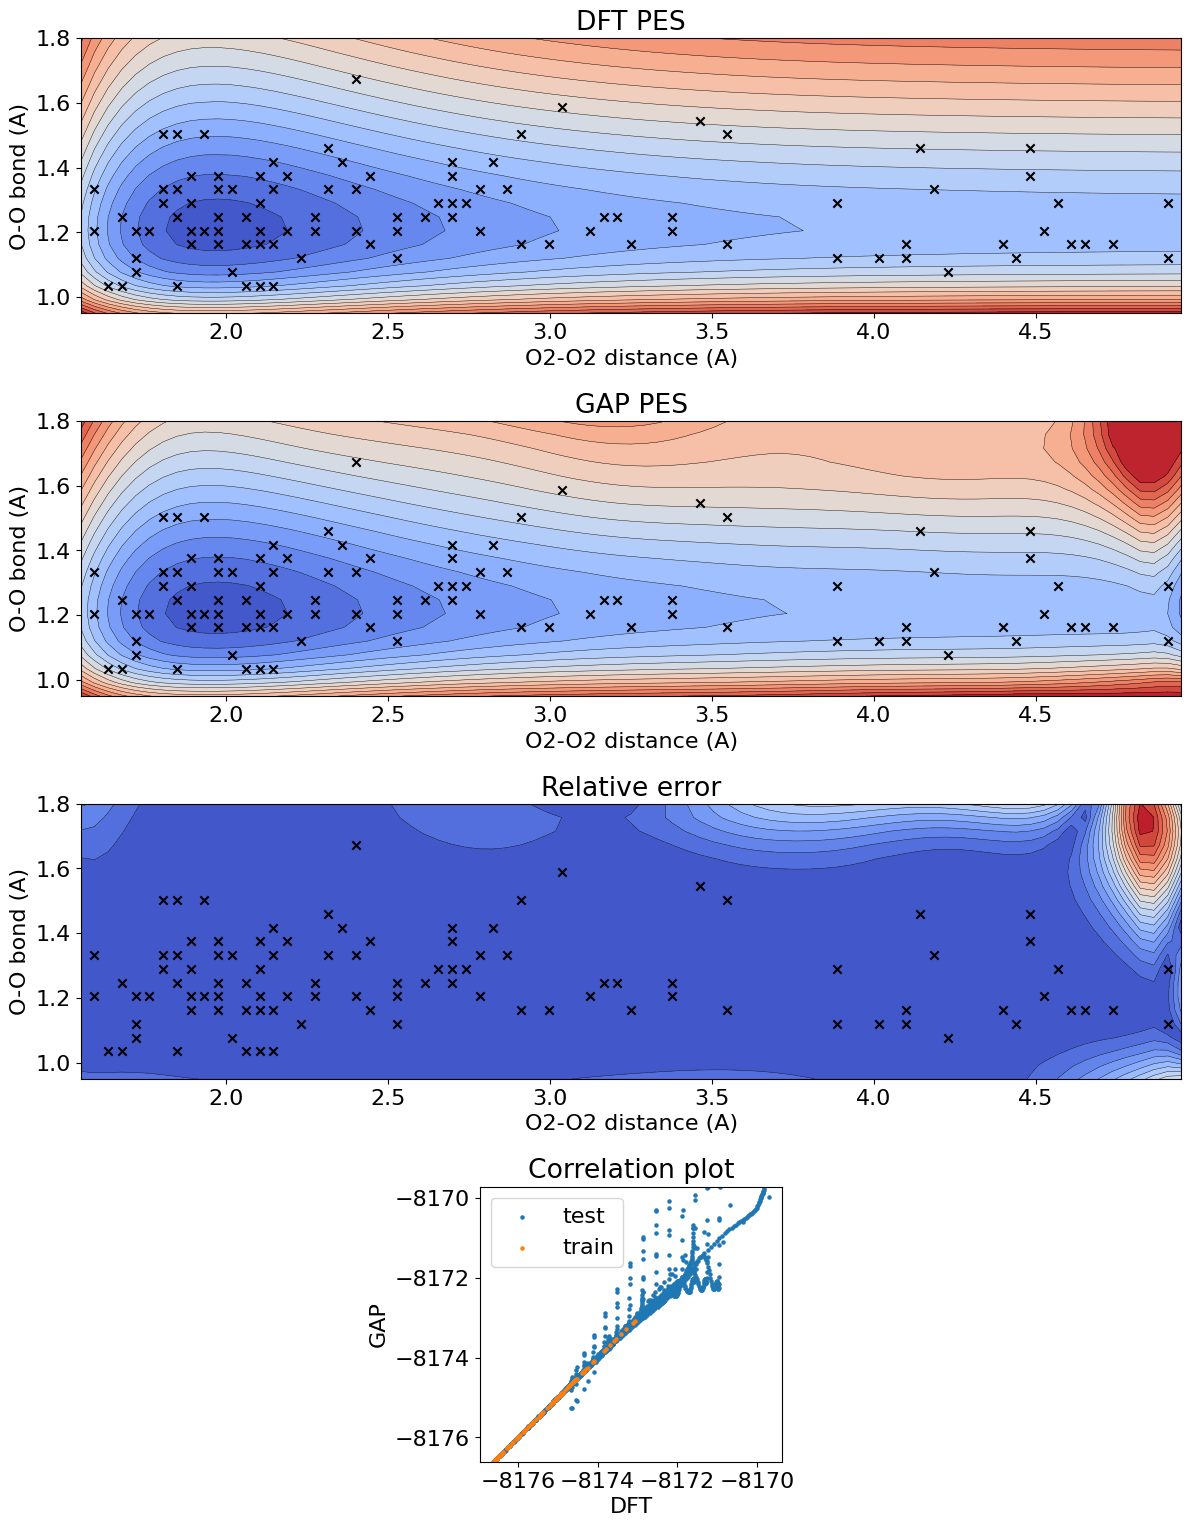

In [9]:
db = ase.io.read('data/O4_2D_scan.xyz',':')
_, _, eng = get_data(db, 'energy_smooth')
r2, R2, eng2, idx2 = grid_data(db, 'energy_smooth')
tdb = []
idx = choose_samples(eng, N=100, T=1.0)
tdb = [db[i] for i in idx]
tr, tR, teng = get_data(tdb, 'energy_smooth')

sig = 1e-10
ds = "soap cutoff=6.0 cutoff_transition_width=1 n_max=12 l_max=6 atom_sigma=0.8 n_Z=1 Z={8} n_species=1 species_Z={8}"

S = sig*np.eye(len(tdb))
c = train_model(tdb, teng, S, ds)
peng = pred_model(tdb, c, db, ds)
pteng = pred_model(tdb, c, tdb, ds)
for i, at in enumerate(db):
    at.info['peng'] = peng[i]

_, _, peng2, _ = grid_data(db, 'peng')
plt.subplot(4,1,1)
plot_data(r2, R2, eng2)
plt.scatter(tR, tr, color='black', marker='x')
plt.title('DFT PES')
plt.subplot(4,1,2)
plot_data(r2, R2, peng2, zlim=[np.min(eng), np.max(eng)])
plt.scatter(tR, tr, color='black', marker='x')
plt.title('GAP PES')
plt.subplot(4,1,3)
plot_data(r2, R2, np.abs(peng2-eng2)/np.abs(eng2), zlim=[0, 1e-3])
plt.scatter(tR, tr, color='black', marker='x')
plt.title('Relative error')
plt.subplot(4,1,4)
plt.scatter(eng, peng, s=5, label='test')
plt.scatter(teng, pteng, s=5, label='train')
plt.gca().set_aspect('equal')
plt.ylim([np.min(eng), np.max(eng)])
plt.xlabel('DFT')
plt.ylabel('GAP')
plt.title('Correlation plot')
plt.legend()

## Intra/Inter separation

Text(0.5, 1.0, 'Inter PES')

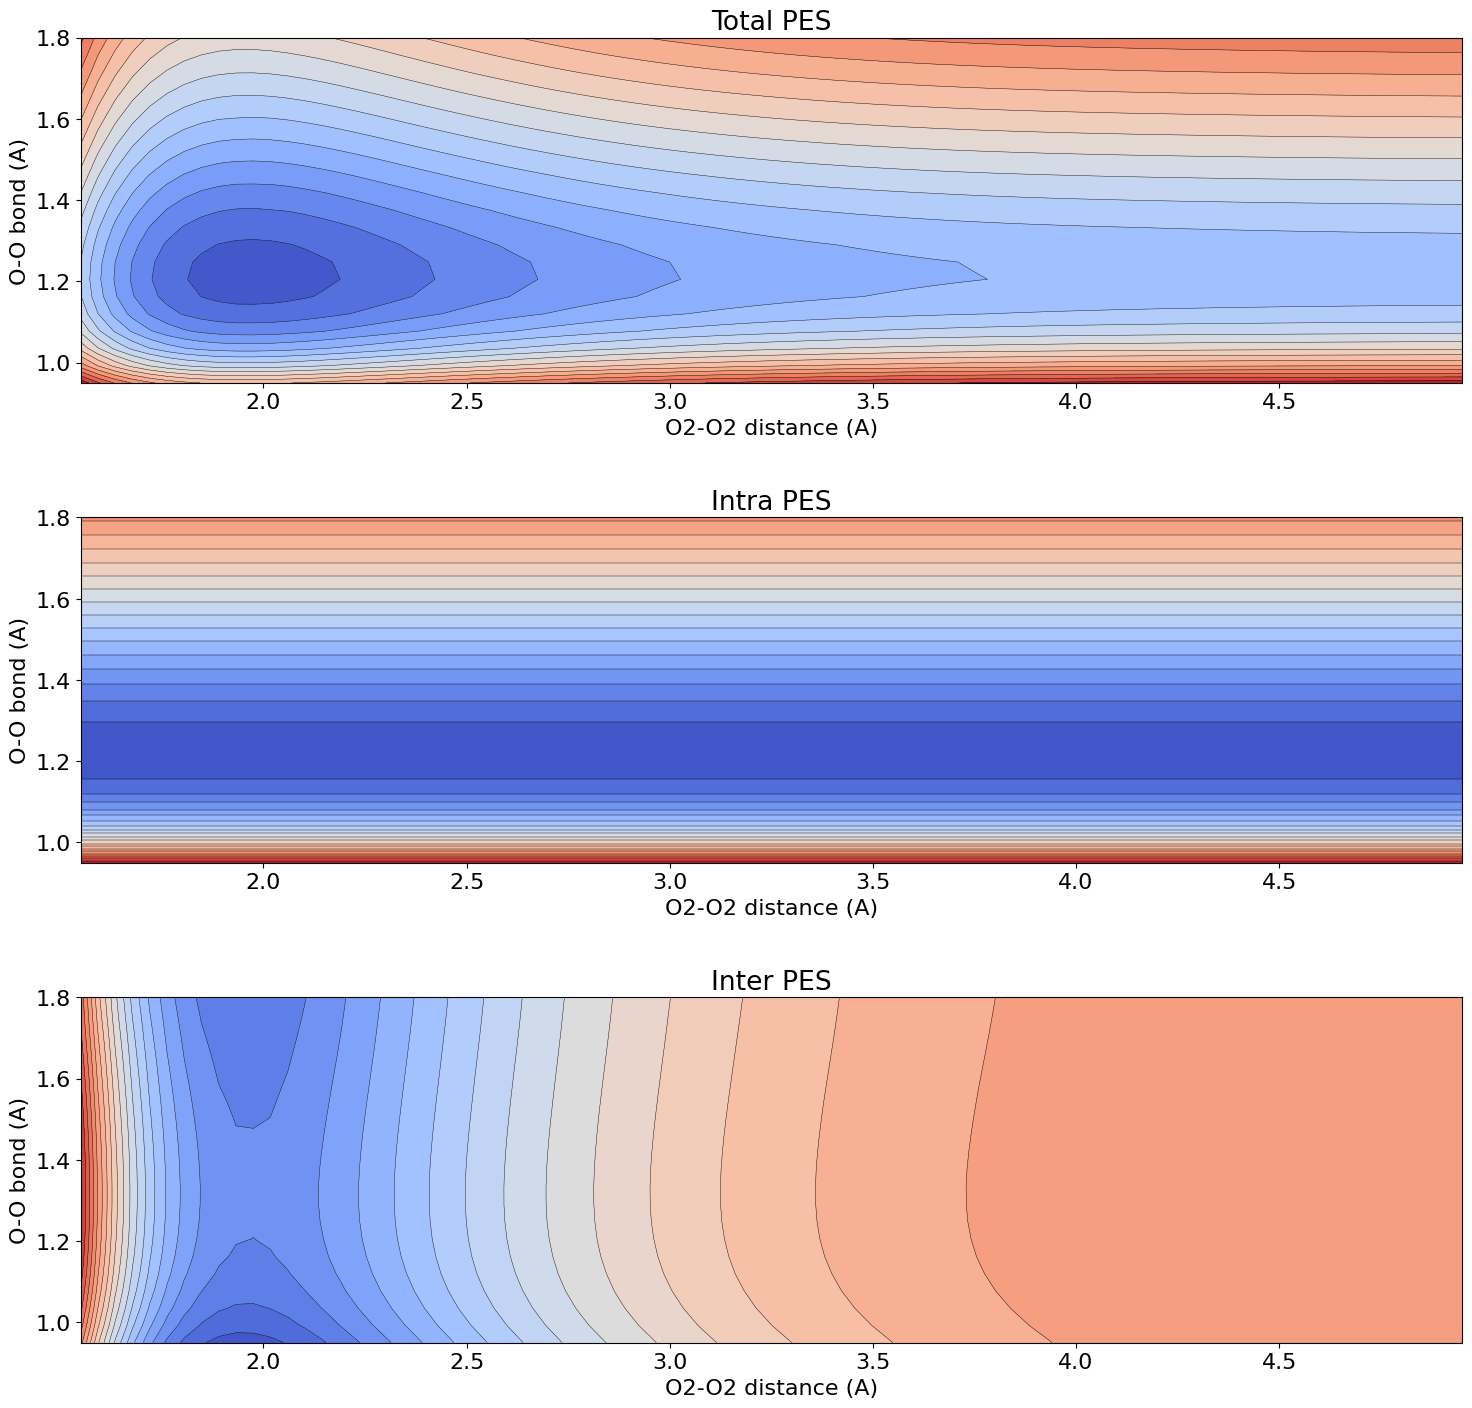

In [10]:
r2, R2, eng2, idx2 = grid_data(db, 'energy_smooth')
eng2intra = eng2[:,-1].reshape(-1,1).repeat(eng2.shape[1], axis=1)
eng2inter = eng2[7,:].reshape(1,-1).repeat(eng2.shape[0], axis=0)
eng2intrainter = eng2-eng2intra-eng2inter
plt.subplot(3,1,1)
plot_data(r2, R2, eng2)
plt.title('Total PES')
plt.subplot(3,1,2)
plot_data(r2, R2, eng2intra)
plt.title('Intra PES')
plt.subplot(3,1,3)
plot_data(r2, R2, eng2inter+eng2intrainter)
plt.title('Inter PES')

Text(0.5, 1.0, 'Total PES (lin)')

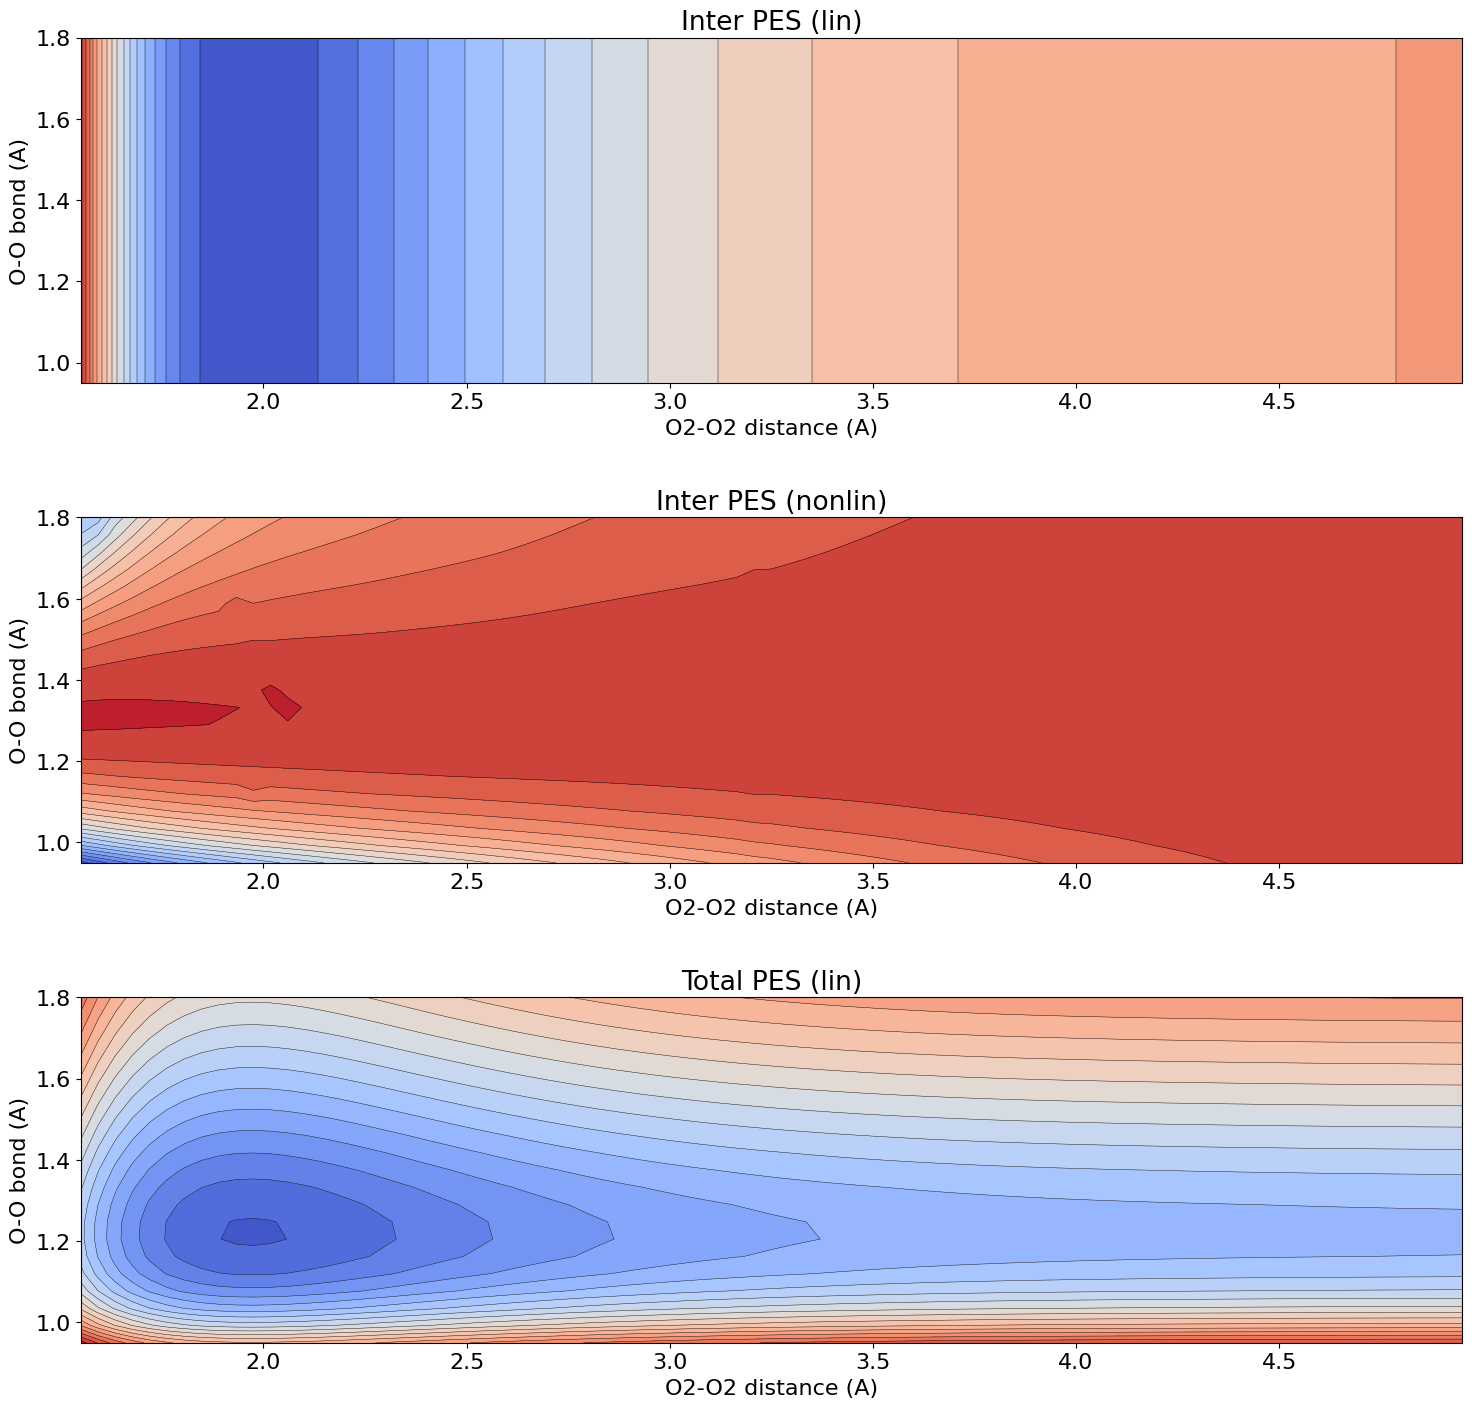

In [11]:
r2, R2, eng2, idx2 = grid_data(db, 'energy_smooth')
eng2intra = eng2[:,-1].reshape(-1,1).repeat(eng2.shape[1], axis=1)
eng2inter = eng2[7,:].reshape(1,-1).repeat(eng2.shape[0], axis=0)
eng2intrainter = eng2-eng2intra-eng2inter
plt.subplot(3,1,1)
plot_data(r2, R2, eng2inter)
plt.title('Inter PES (lin)')
plt.subplot(3,1,2)
plot_data(r2, R2, eng2intrainter)
plt.title('Inter PES (nonlin)')
plt.subplot(3,1,3)
plot_data(r2, R2, eng2-eng2intrainter)
plt.title('Total PES (lin)')

# Tests on configs sampled with MD

In [2]:
import os, sys, shutil
from aseMolec import extAtoms as ea
from aseMolec import anaAtoms as aa
from aseMolec import pltProps as pp
import matplotlib.pyplot as plt
import numpy as np
import ase.io
from ase.io import Trajectory
from ase import Atoms
from ase.build import molecule
from ase import units
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.langevin import Langevin
from ase.calculators.orca import ORCA
from ase.io.opls import OPLSff, OPLSStructure
from quippy import descriptors

plt.rcParams['figure.figsize'] = [8, 6]
plt.rc('axes.formatter', useoffset=False)

def calc_rmse(dat1, dat2):
    return np.sqrt(np.mean((dat1-dat2)**2))

def plot_eng(dft_eng_train, gap_eng_train, dft_eng_test, gap_eng_test):
    RMSE_train = calc_rmse(dft_eng_train, gap_eng_train)
    RMSE_test = calc_rmse(dft_eng_test, gap_eng_test)
    plt.scatter(dft_eng_train, gap_eng_train, label='train RMSE: {0:.3f}'.format(RMSE_train))
    plt.scatter(dft_eng_test, gap_eng_test, label='test RMSE: {0:.3f}'.format(RMSE_test))
    plt.xlabel('DFT Energy (eV)')
    plt.ylabel('GAP Energy (eV)')
    plt.legend()
    plt.show()

ds = "soap cutoff=6.0 cutoff_transition_width=1 n_max=8 l_max=4 atom_sigma=0.8 n_Z=1 Z={8} n_species=1 species_Z={8}"

def calc_quip_descr(db, desc_str):
    ds = descriptors.Descriptor(desc_str)
    ps = ds.calc(db)
    return np.vstack([p['data'][:,:-1] for p in ps])

def calc_kernel(dat1, dat2, desc_str=ds):
    ps1 = calc_quip_descr(dat1, desc_str)
    ps2 = calc_quip_descr(dat2, desc_str)
    K_atomic = np.matmul(ps1, ps2.T)**4
    K = np.add.reduceat(K_atomic, np.arange(0, K_atomic.shape[0], 4), axis=0)
    K = np.add.reduceat(K, np.arange(0, K.shape[1], 4), axis=1)
    return K

def train_model(dat, dft, S):
    K = calc_kernel(dat, dat)
    c,_,_,_ = np.linalg.lstsq(K+S, dft, rcond=None)
    return c

def pred_model(ref, c, dat):
    K = calc_kernel(dat, ref)
    gap = np.matmul(K, c)
    return gap

# Prepare train/test split

In [16]:
#train/test split
idx_split = 50

#configs
liq_set = ase.io.read('data/moldyn.xyz', ':')
sml_set = ase.io.read('data/isomol.xyz', ':')
liq_set_trn = liq_set[:idx_split]
sml_set_trn = sml_set[:idx_split]
liq_set_tst = liq_set[idx_split:]
sml_set_tst = sml_set[idx_split:]

#dft data
liq_dft = ea.get_prop(ase.io.read('data/dftdata.xyz', ':'), 'info', 'total_energy')
sml_dft = ea.get_prop(ase.io.read('data/dftdata.xyz', ':'), 'info', 'intra_energy')
liq_dft_trn = liq_dft[:idx_split]
sml_dft_trn = sml_dft[:idx_split]
liq_dft_tst = liq_dft[idx_split:]
sml_dft_tst = sml_dft[idx_split:]
dif_dft_trn = liq_dft_trn-sml_dft_trn
dif_dft_tst = liq_dft_tst-sml_dft_tst

#testing function intra/inter split
def test_intra_inter(set_trn, c):
    rmse = []
    liq_gap_trn = pred_model(set_trn, c, liq_set_trn)
    liq_gap_tst = pred_model(set_trn, c, liq_set_tst)
    sml_gap_trn = pred_model(set_trn, c, sml_set_trn)    
    sml_gap_tst = pred_model(set_trn, c, sml_set_tst)
    dif_gap_trn = liq_gap_trn-sml_gap_trn
    dif_gap_tst = liq_gap_tst-sml_gap_tst
    rmse += [calc_rmse(sml_gap_trn, sml_dft_trn)]
    rmse += [calc_rmse(sml_gap_tst, sml_dft_tst)]
    rmse += [calc_rmse(dif_gap_trn, dif_dft_trn)]
    rmse += [calc_rmse(dif_gap_tst, dif_dft_tst)]
    return [sml_gap_trn, sml_gap_tst, dif_gap_trn, dif_gap_tst], rmse

def plot_intra_inter(set_trn, c):
    gap, _ = test_intra_inter(set_trn, c)
    plt.figure(figsize=(10,8), dpi=200)
    plt.subplot(1,2,1)
    pp.plot_prop(sml_dft_trn, gap[0], title='Intra-energy', labs=['DFT', 'GAP'], xy = [0.35,0.04])
    pp.plot_prop(sml_dft_tst, gap[1], title='Intra-energy', labs=['DFT', 'GAP'], xy = [0.35,0.15])
    plt.subplot(1,2,2)
    pp.plot_prop(dif_dft_trn, gap[2], title='Inter-energy', labs=['DFT', 'GAP'], xy = [0.35,0.04])
    pp.plot_prop(dif_dft_tst, gap[3], title='Inter-energy', labs=['DFT', 'GAP'], xy = [0.35,0.15])    

def scan_regularization(set_trn, eng_trn, sig_col):
    rmse_col = []
    for sig in sig_col:
        S = sig*np.eye(len(set_trn))
        c = train_model(set_trn, eng_trn, S)
        rmse_col += [test_intra_inter(set_trn, c)[1]]
    return np.array(rmse_col)

def scan_regularization_2D(set_trn, eng_trn, intra_sig, inter_sig, L=np.array([])):
    intra_rmse_col = []
    inter_rmse_col = []
    for intra_sig in intra_sig_col:
        intra_rmse_buf = []
        inter_rmse_buf = []
        for inter_sig in inter_sig_col:
            S = np.diag([inter_sig]*len(liq_set_trn)+[intra_sig]*len(sml_set_trn))
            if L.size:
                S = np.matmul(np.linalg.inv(L), S)
            c = train_model(set_trn, eng_trn, S)
            rmse = test_intra_inter(set_trn, c)[1]
            intra_rmse_buf += [rmse[1]]
            inter_rmse_buf += [rmse[3]]
        intra_rmse_col += [intra_rmse_buf]
        inter_rmse_col += [inter_rmse_buf]
    return np.array(intra_rmse_col), np.array(inter_rmse_col)

def plot_regularization(sig_col, rmse_col):
    idx = np.argmin(rmse_col, axis=0)[[1,3]]
    plt.figure(figsize=(10,4), dpi=200)
    plt.subplot(1,2,1)
    plt.plot(sig_col, rmse_col[:,0], label='Train')
    plt.plot(sig_col, rmse_col[:,1], label='Test')
    plt.plot(sig_col[idx[0]], rmse_col[idx[0], 1], '.', color='green')
    plt.plot(sig_col[idx[1]], rmse_col[idx[1], 1], '.', color='red')
    plt.xscale('log')
    plt.xlabel('Sigma')
    plt.ylabel('RMSE (eV)')
    plt.title('Intra-Energy')
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(sig_col, rmse_col[:,2], label='Train')
    plt.plot(sig_col, rmse_col[:,3], label='Test')
    plt.plot(sig_col[idx[0]], rmse_col[idx[0], 3], '.', color='green')
    plt.plot(sig_col[idx[1]], rmse_col[idx[1], 3], '.', color='red')
    plt.xscale('log')
    plt.xlabel('Sigma')
    plt.ylabel('RMSE (eV)')
    plt.title('Inter-Energy')
    plt.legend()
    print(sig_col[idx[0]])
    print(sig_col[idx[1]])
    return idx

def plot_regularization_2D(intra_sig_col, inter_sig_col, intra_rmse_col, inter_rmse_col):
    plt.figure(figsize=(10,4), dpi=200)
    plt.subplot(1,2,1)
    zlim = 0.01
    idx_intra = np.unravel_index(intra_rmse_col.argmin(), intra_rmse_col.shape)
    intra_rmse = intra_rmse_col.copy()
    intra_rmse[intra_rmse>zlim] = zlim
    plt.contourf(intra_sig_col, inter_sig_col, intra_rmse.T, 100, cmap='bwr')
    plt.plot(intra_sig_col[idx_intra[0]], inter_sig_col[idx_intra[1]], '.', color='yellow', markersize=10, zorder=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('intra-sigma')
    plt.ylabel('inter-sigma')
    cbar = plt.colorbar()
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    plt.subplot(1,2,2)
    zlim = 0.3
    idx_inter = np.unravel_index(inter_rmse_col.argmin(), inter_rmse_col.shape)
    inter_rmse = inter_rmse_col.copy()
    inter_rmse[inter_rmse>zlim] = zlim
    plt.contourf(intra_sig_col, inter_sig_col, inter_rmse.T, 100, cmap='bwr')
    plt.plot(intra_sig_col[idx_inter[0]], inter_sig_col[idx_inter[1]], '.', color='yellow', markersize=10, zorder=1)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('intra-sigma')
    plt.ylabel('inter-sigma')
    cbar = plt.colorbar()
    cbar.formatter.set_powerlimits((0, 0))
    cbar.update_ticks()
    print(intra_sig_col[idx_inter[0]])
    print(inter_sig_col[idx_inter[1]])
    return idx_inter

# Unified GPR, single sigma

1e-12
0.018329807108324374


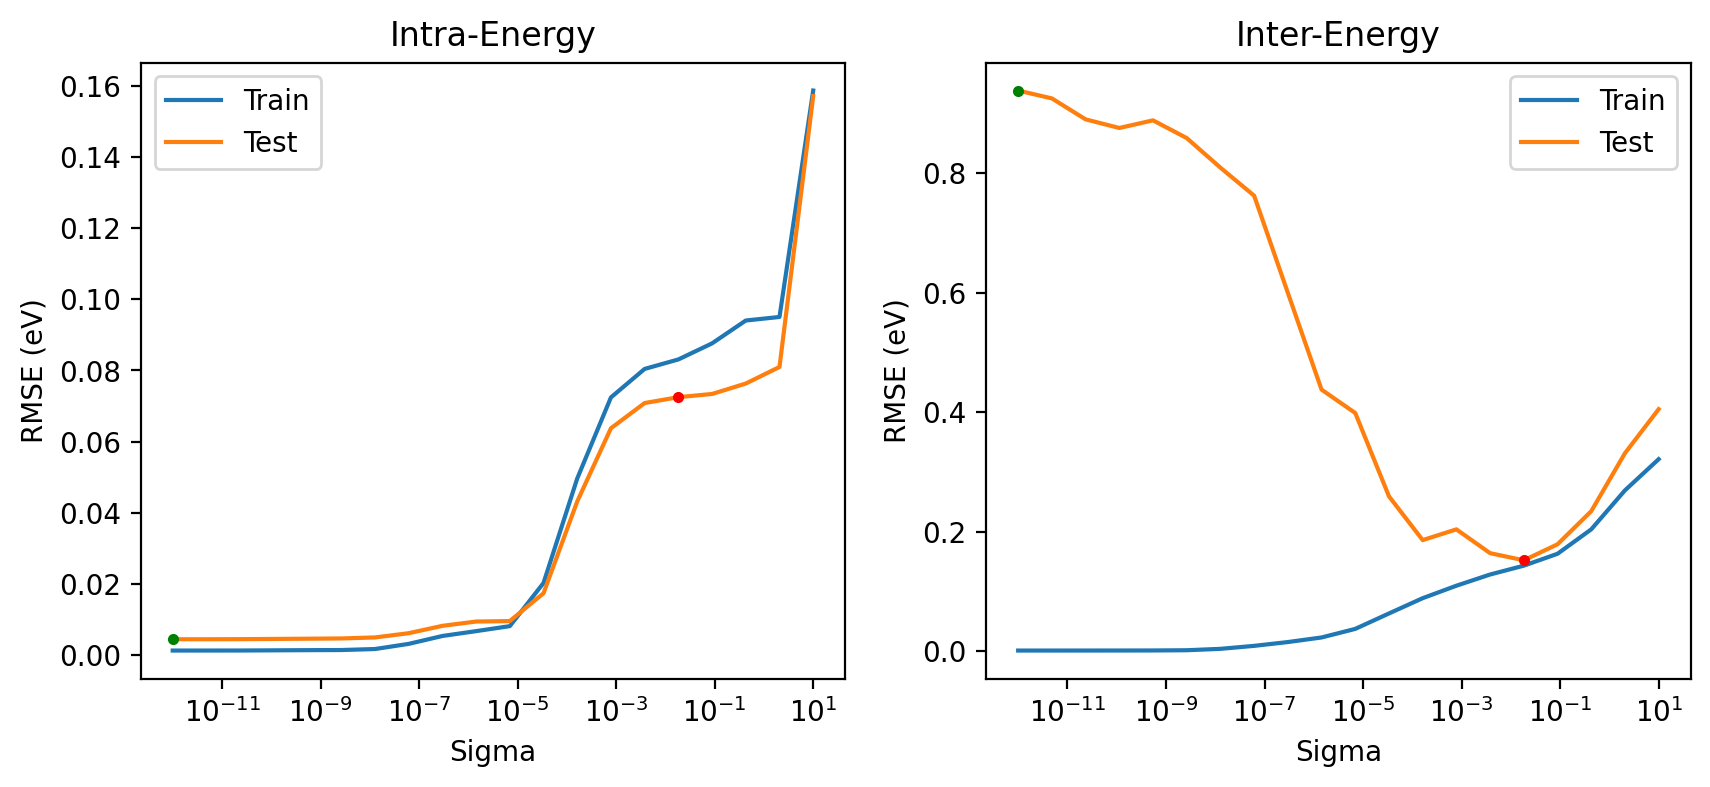

In [17]:
set_trn = liq_set_trn+sml_set_trn
eng_trn = np.hstack([liq_dft_trn, sml_dft_trn])
sig_col = np.geomspace(1.e-12, 1.e+1, num=20)
rmse_col = scan_regularization(set_trn, eng_trn, sig_col)
idx = plot_regularization(sig_col, rmse_col)

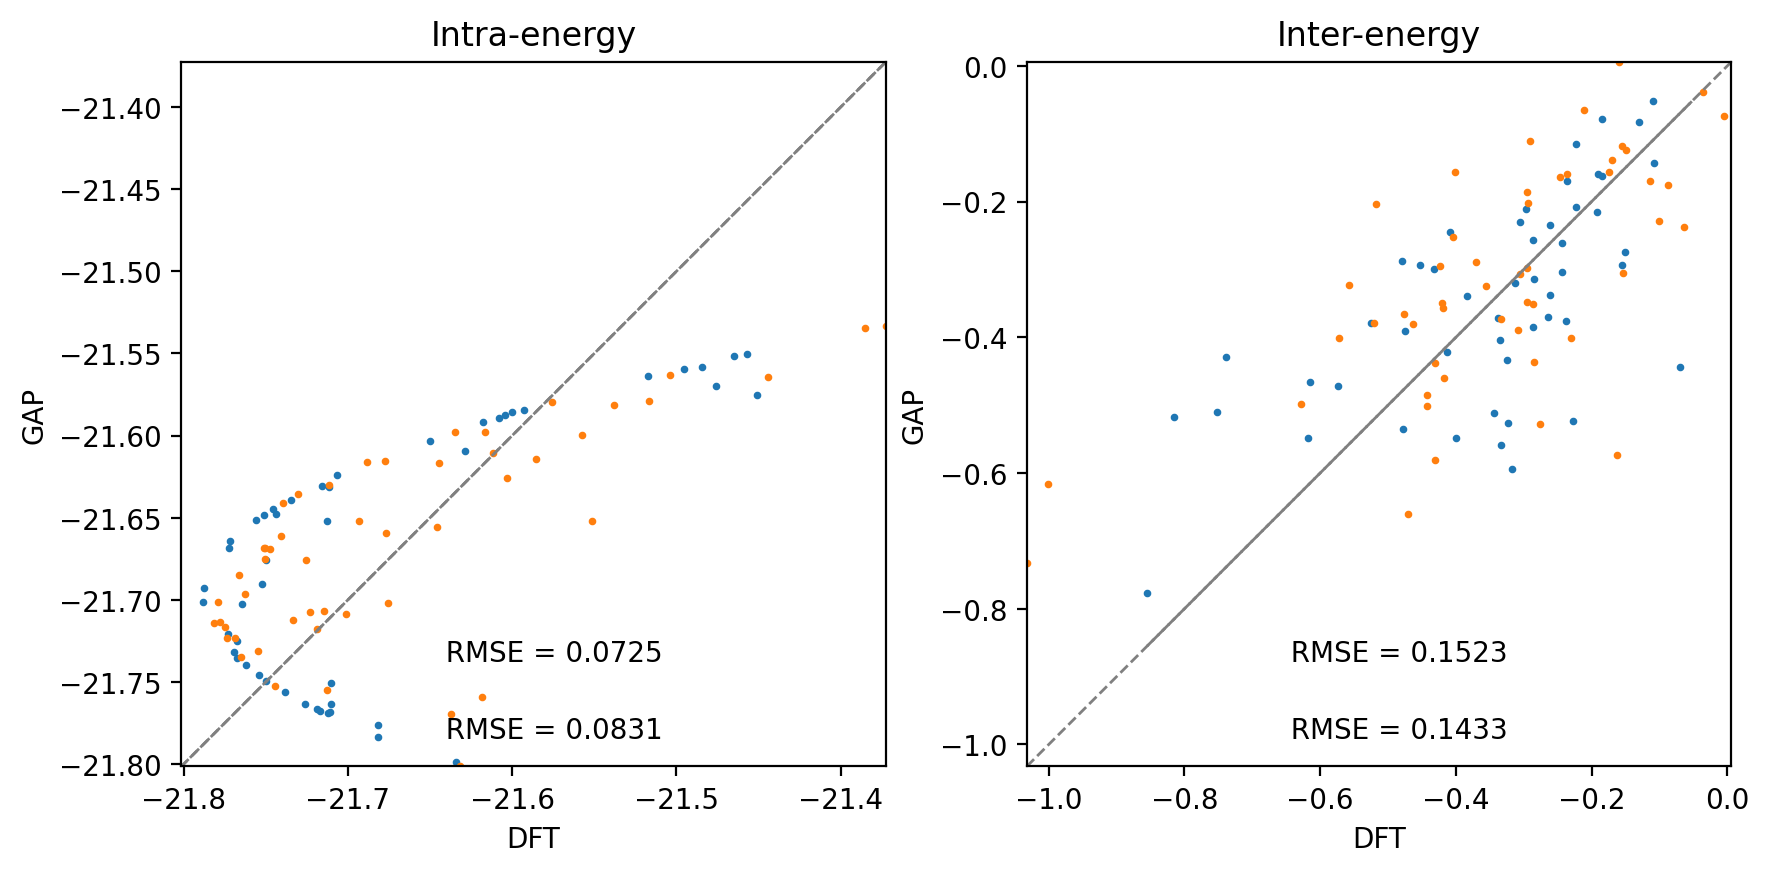

In [18]:
sig = sig_col[idx[1]]
S = sig*np.eye(len(set_trn))
c = train_model(set_trn, eng_trn, S)
plot_intra_inter(set_trn, c)

# Intra GPR, molecule configs

1e-12
0.08858667904100832


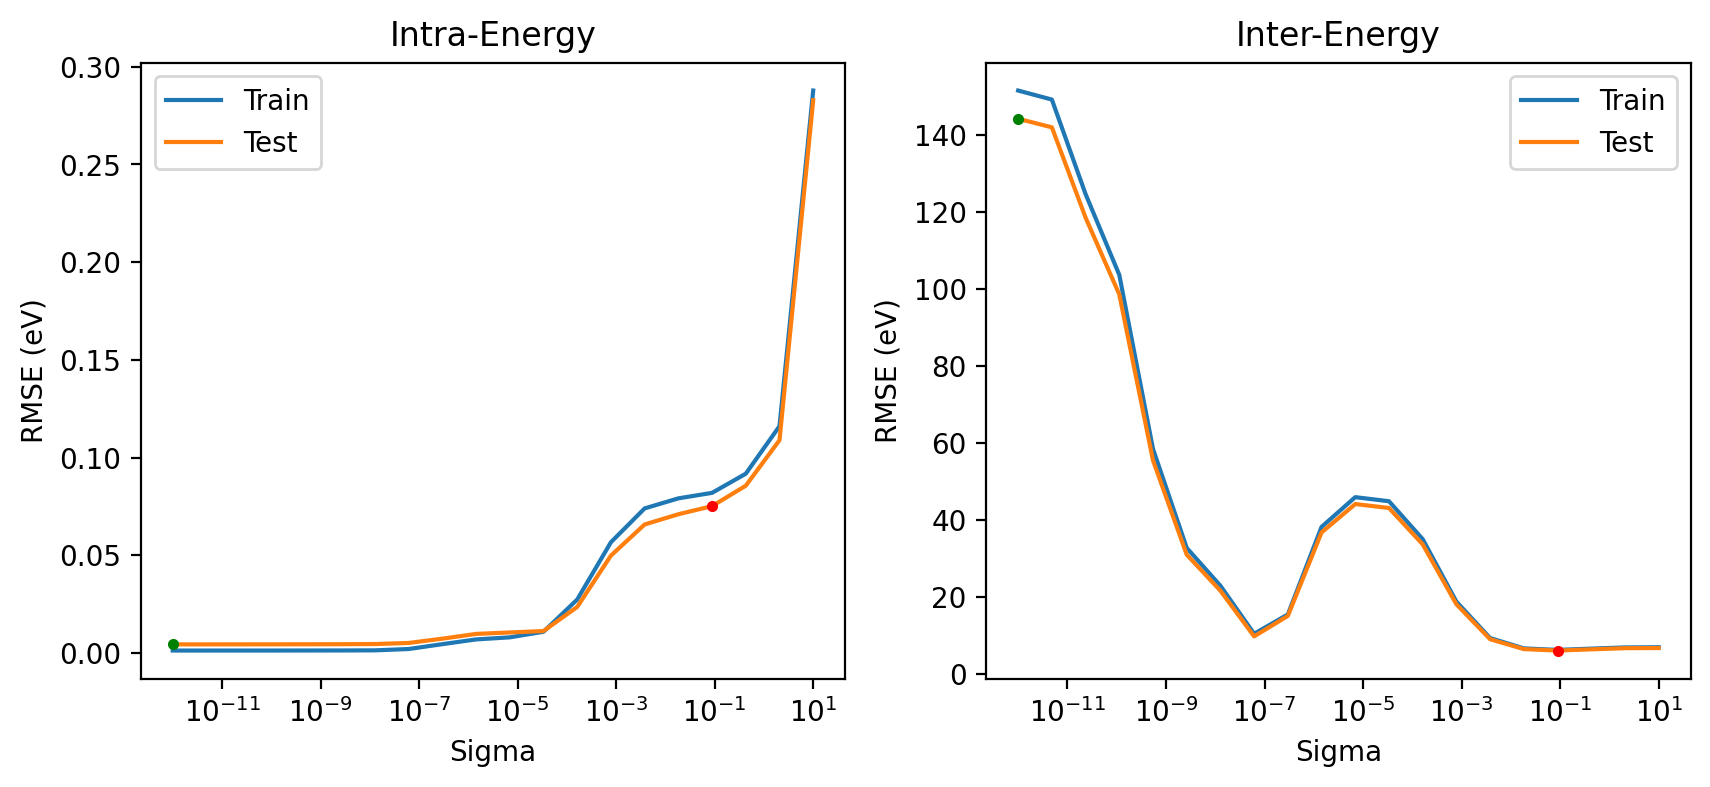

In [7]:
set_trn = sml_set_trn
eng_trn = sml_dft_trn
sig_col = np.geomspace(1.e-12, 1.e+1, num=20)
rmse_col = scan_regularization(set_trn, eng_trn, sig_col)
idx = plot_regularization(sig_col, rmse_col)

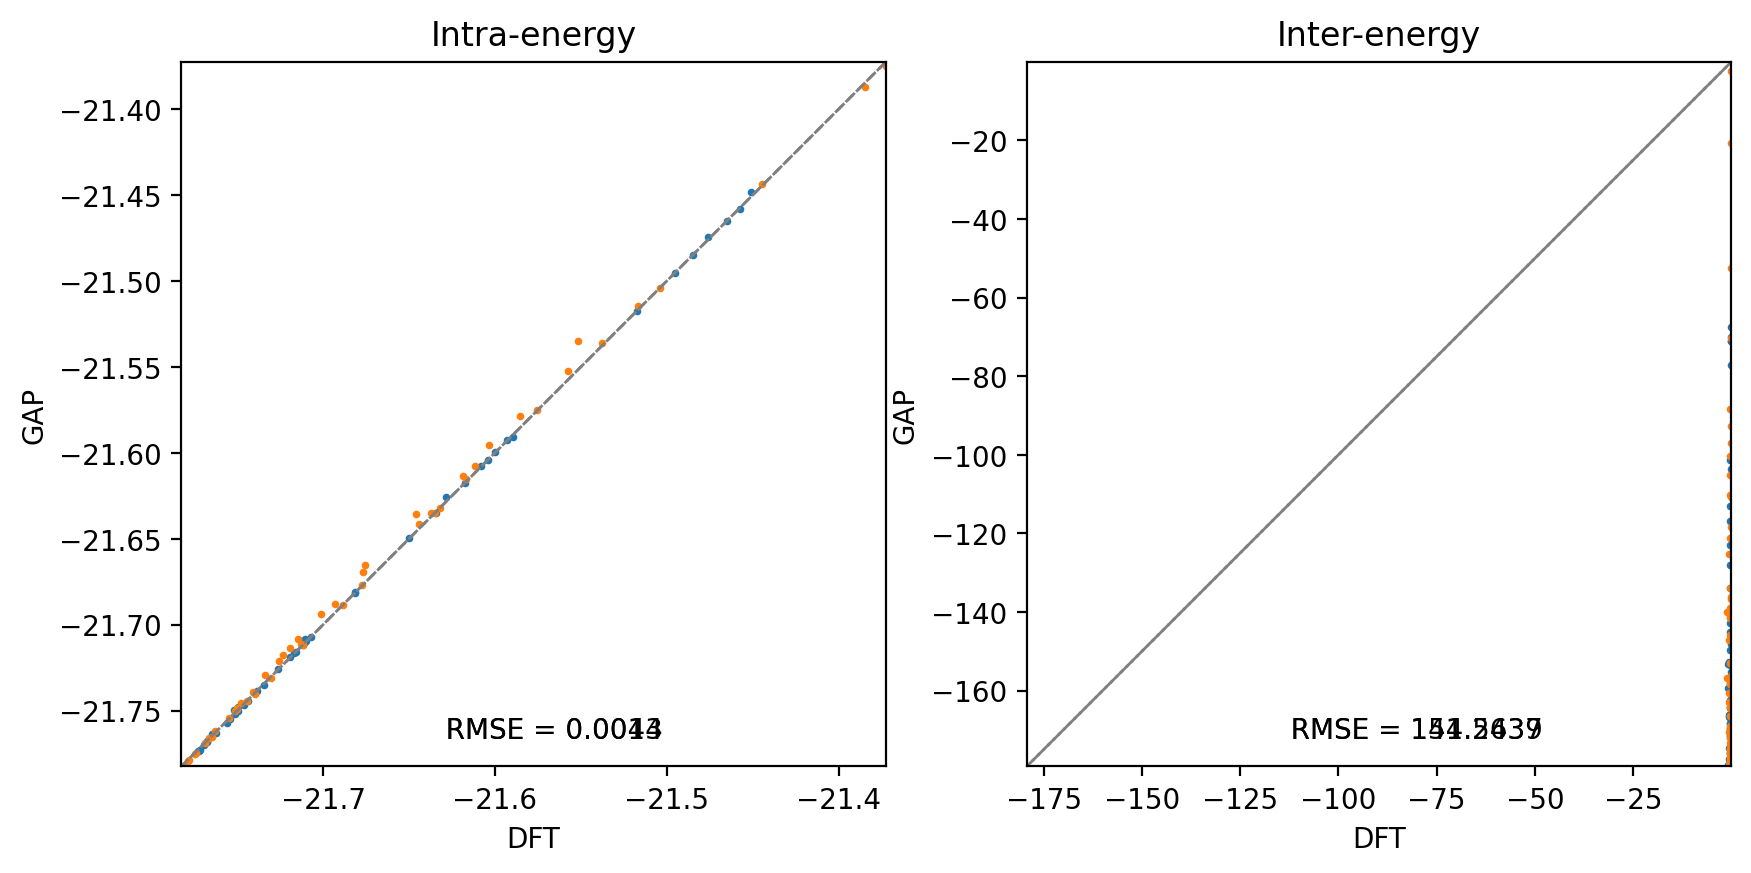

In [8]:
sig = sig_col[idx[0]]
S = sig*np.eye(len(set_trn))
c = train_model(set_trn, eng_trn, S)
plot_intra_inter(set_trn, c)

# Inter GPR, mixed configs

10.0
0.0007847599703514623


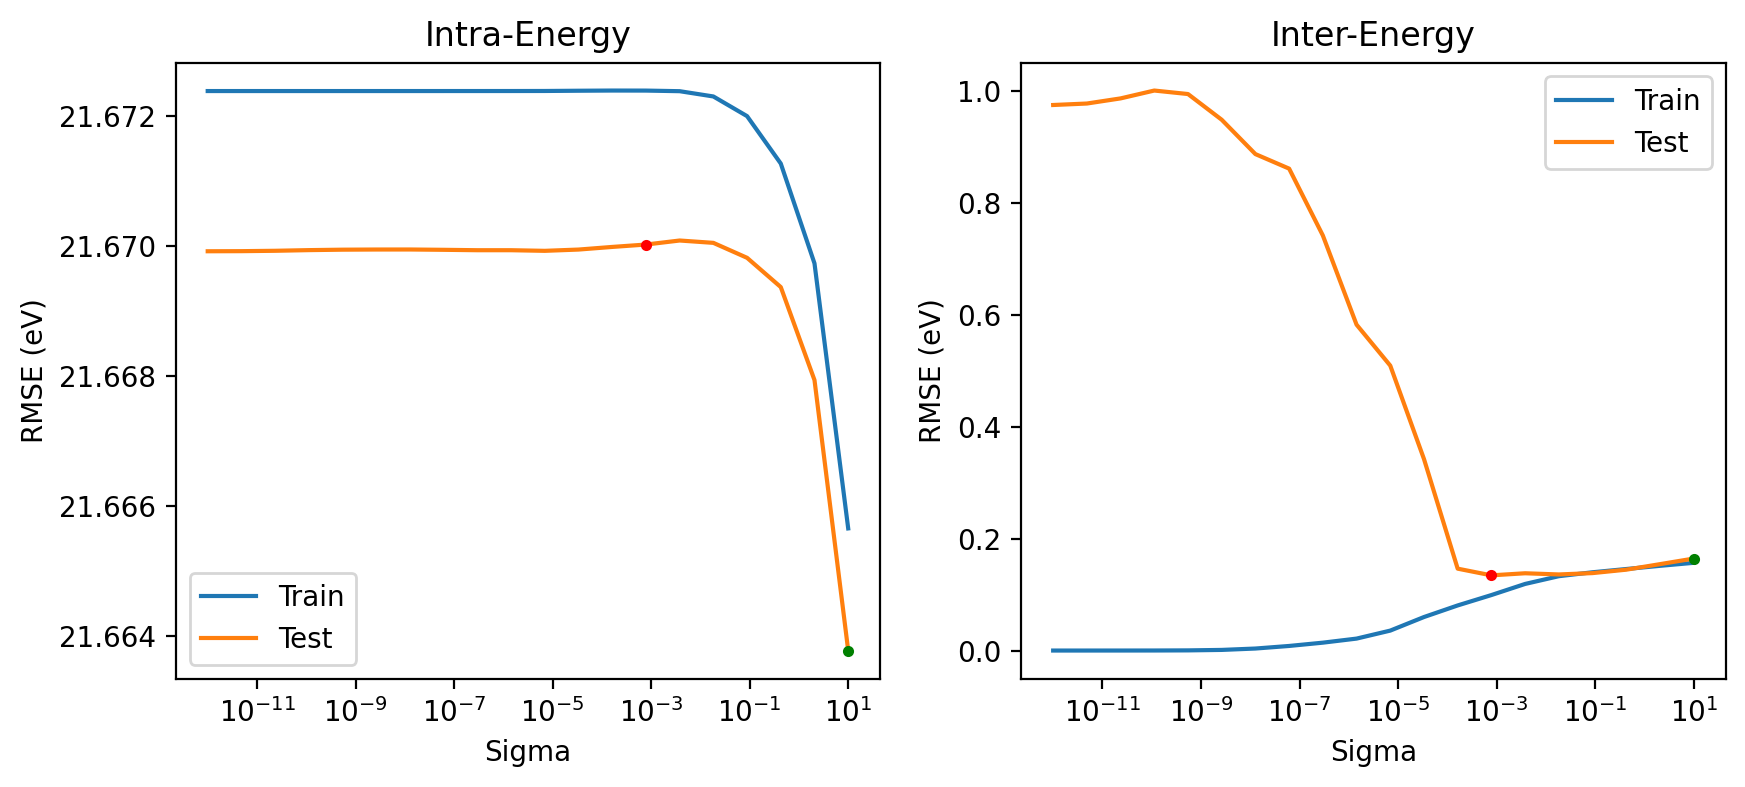

In [10]:
set_trn = liq_set_trn+sml_set_trn
eng_trn = np.hstack([liq_dft_trn-sml_dft_trn, np.zeros(len(sml_set_trn))])
sig_col = np.geomspace(1.e-12, 1.e+1, num=20)
rmse_col = scan_regularization(set_trn, eng_trn, sig_col)
idx = plot_regularization(sig_col, rmse_col)

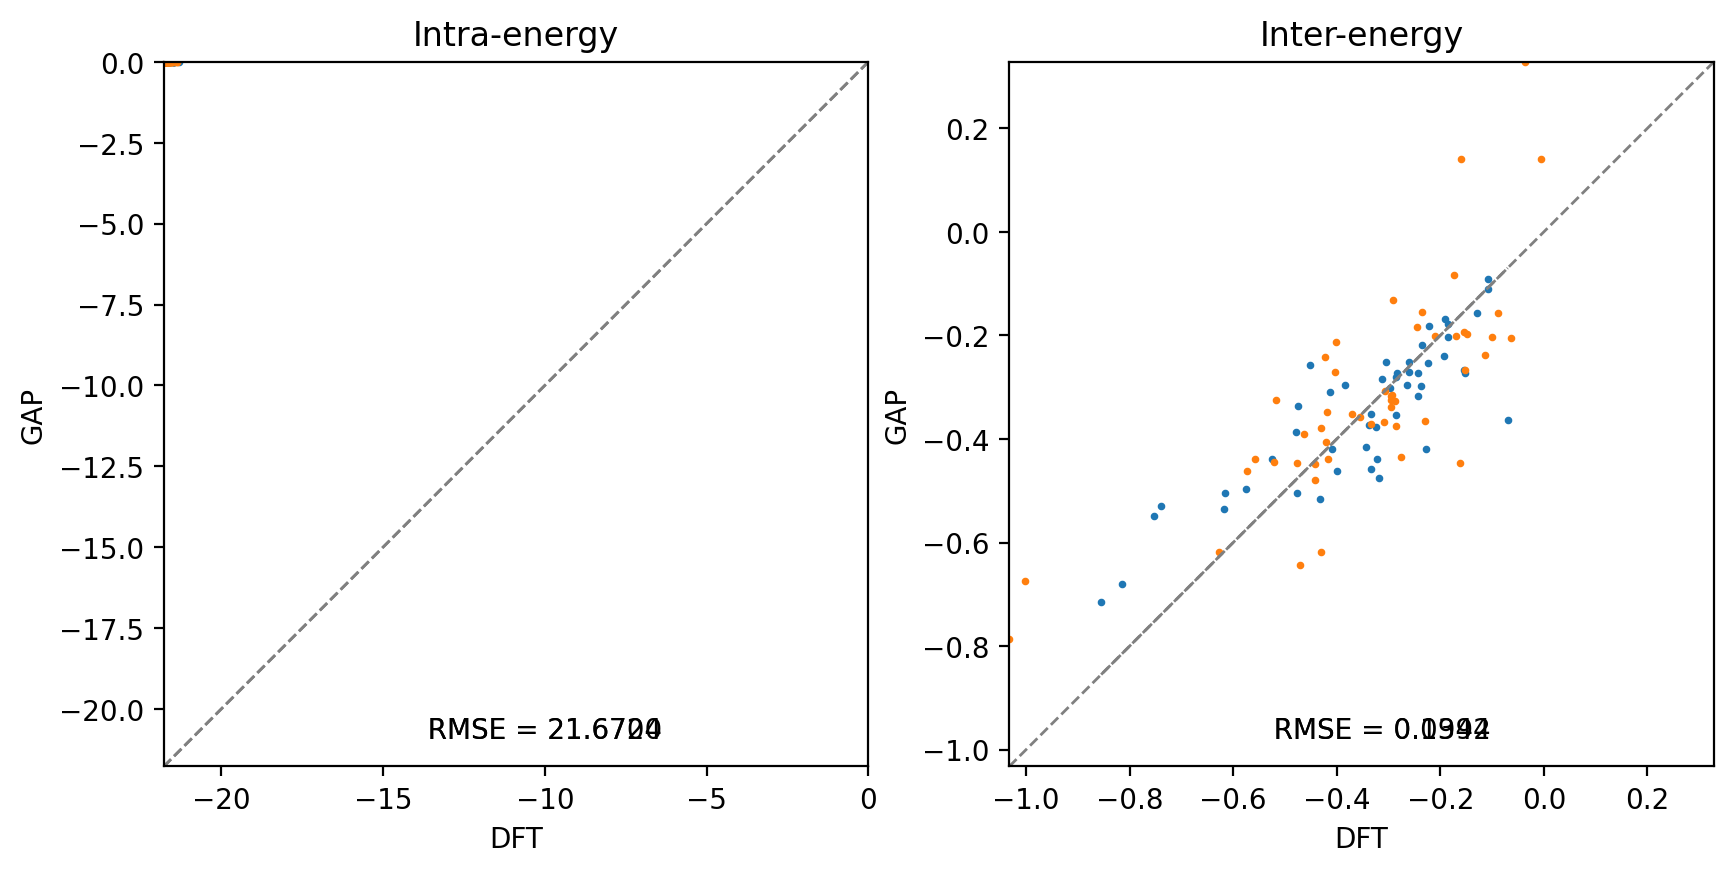

In [11]:
sig = sig_col[idx[1]]
S = sig*np.eye(len(set_trn))
c = train_model(set_trn, eng_trn, S)
plot_intra_inter(set_trn, c)

# Unified GPR, separate sigmas

0.001
0.01873817422860387


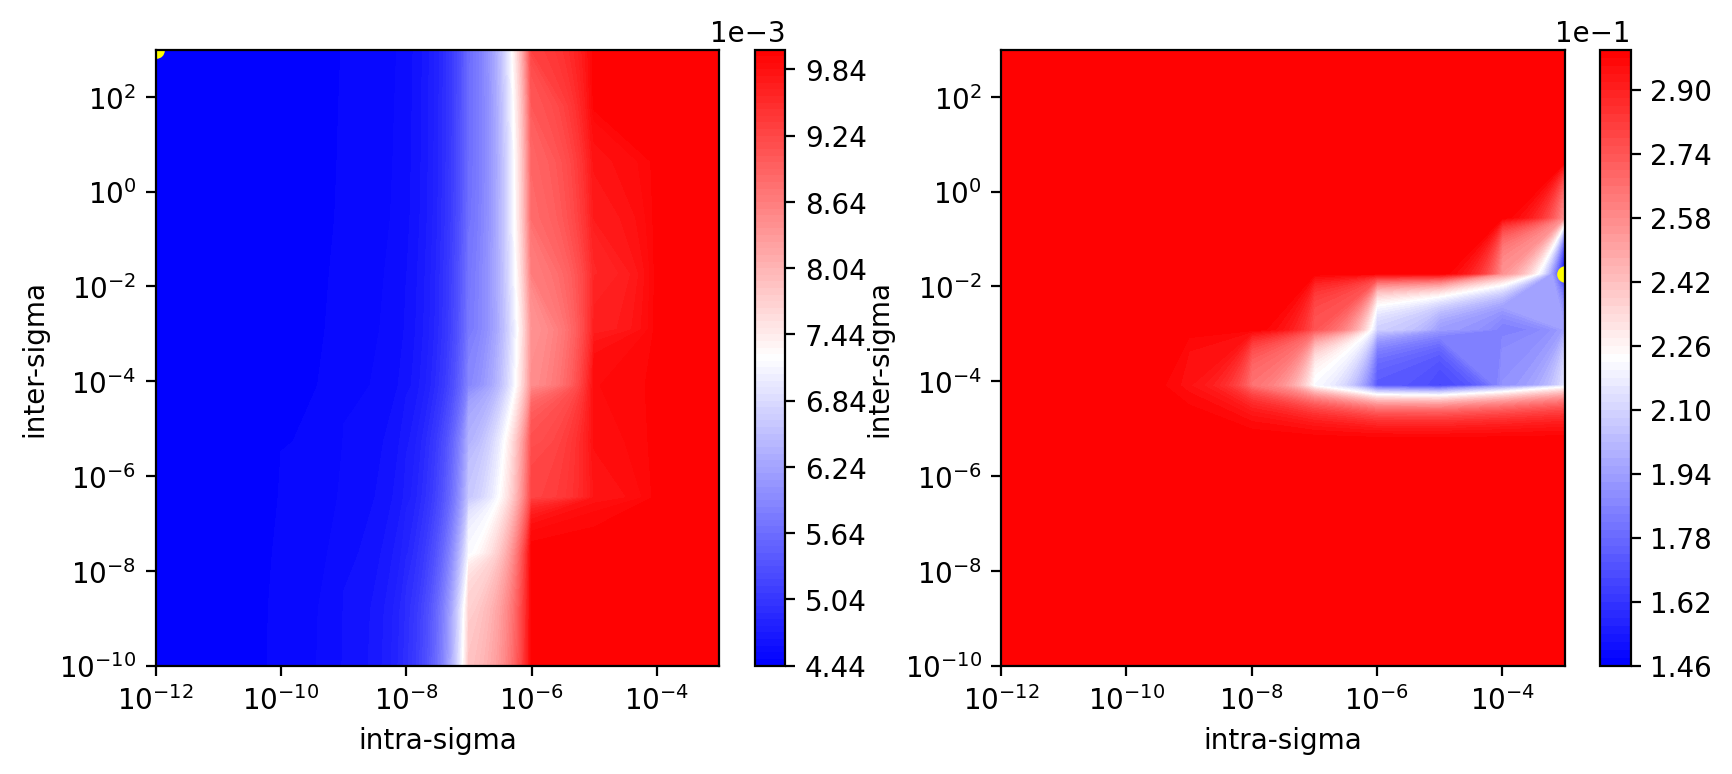

In [12]:
set_trn = liq_set_trn+sml_set_trn
eng_trn = np.hstack([liq_dft_trn, sml_dft_trn])
intra_sig_col = np.geomspace(1.e-12, 1.e-3, num=10)
inter_sig_col = np.geomspace(1.e-10, 1.e+3, num=12)
intra_rmse_col, inter_rmse_col = scan_regularization_2D(set_trn, eng_trn, intra_sig_col, inter_sig_col)
idx = plot_regularization_2D(intra_sig_col, inter_sig_col, intra_rmse_col, inter_rmse_col)

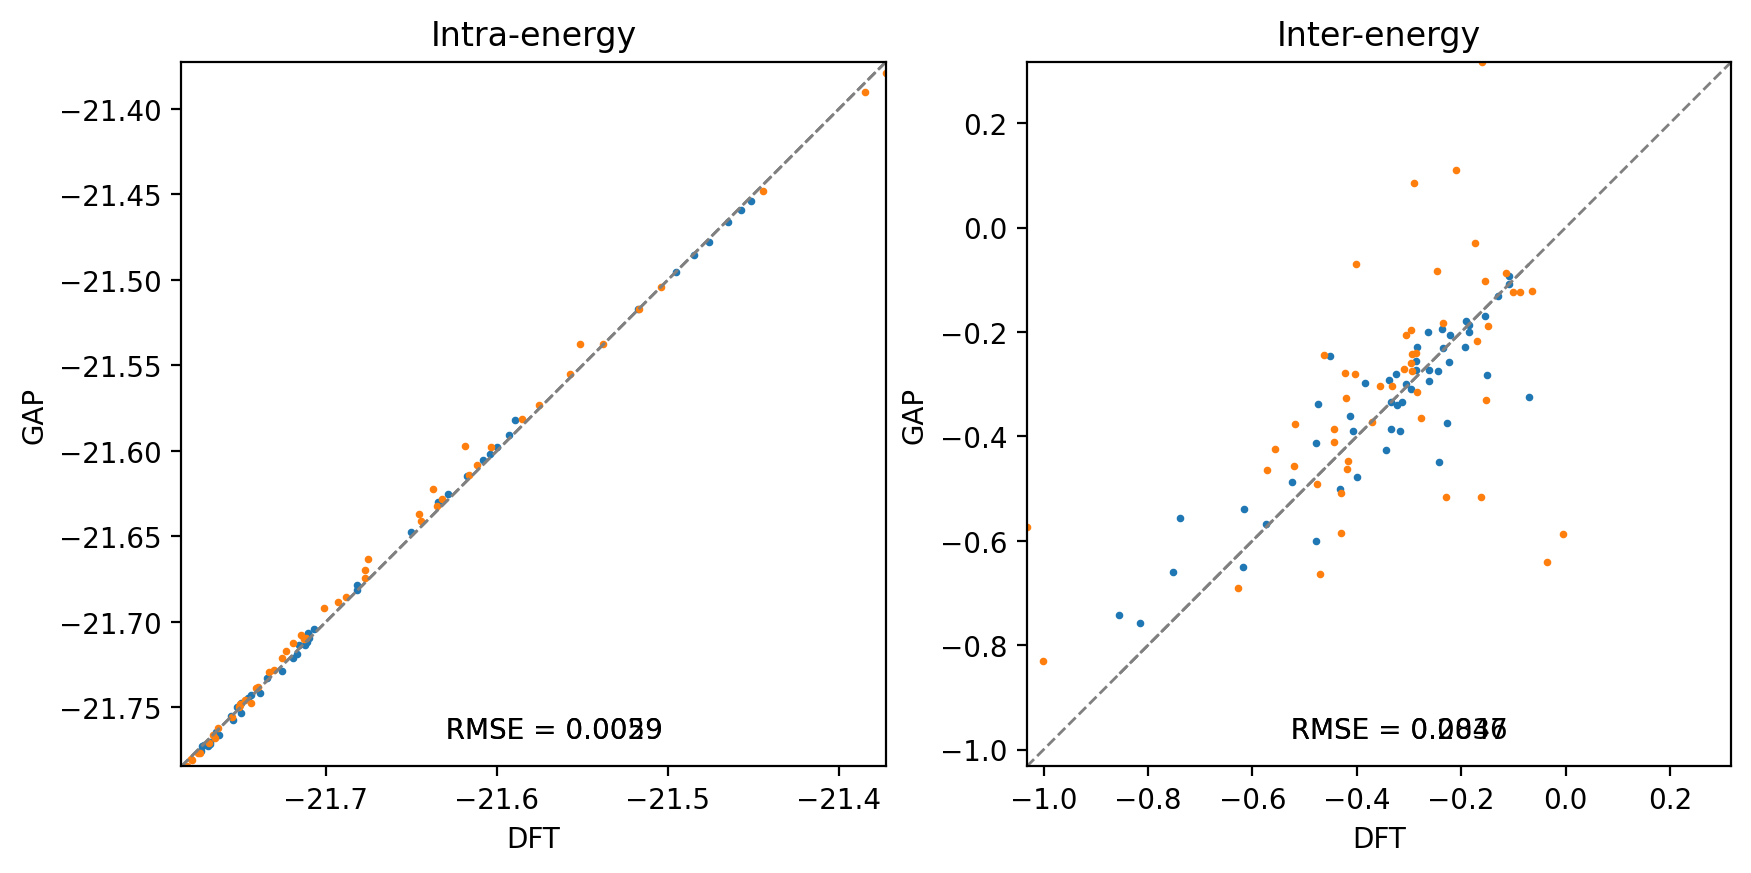

In [13]:
# intra_sig = intra_sig_col[idx[0]]
# inter_sig = inter_sig_col[idx[1]]
intra_sig = 1e-7
inter_sig = 1e-4
S = np.diag([inter_sig]*len(liq_set_trn)+[intra_sig]*len(sml_set_trn))
c = train_model(set_trn, eng_trn, S)
plot_intra_inter(set_trn, c)

# Unified GPR, non-diagonal sigmas

1e-11
0.01873817422860387


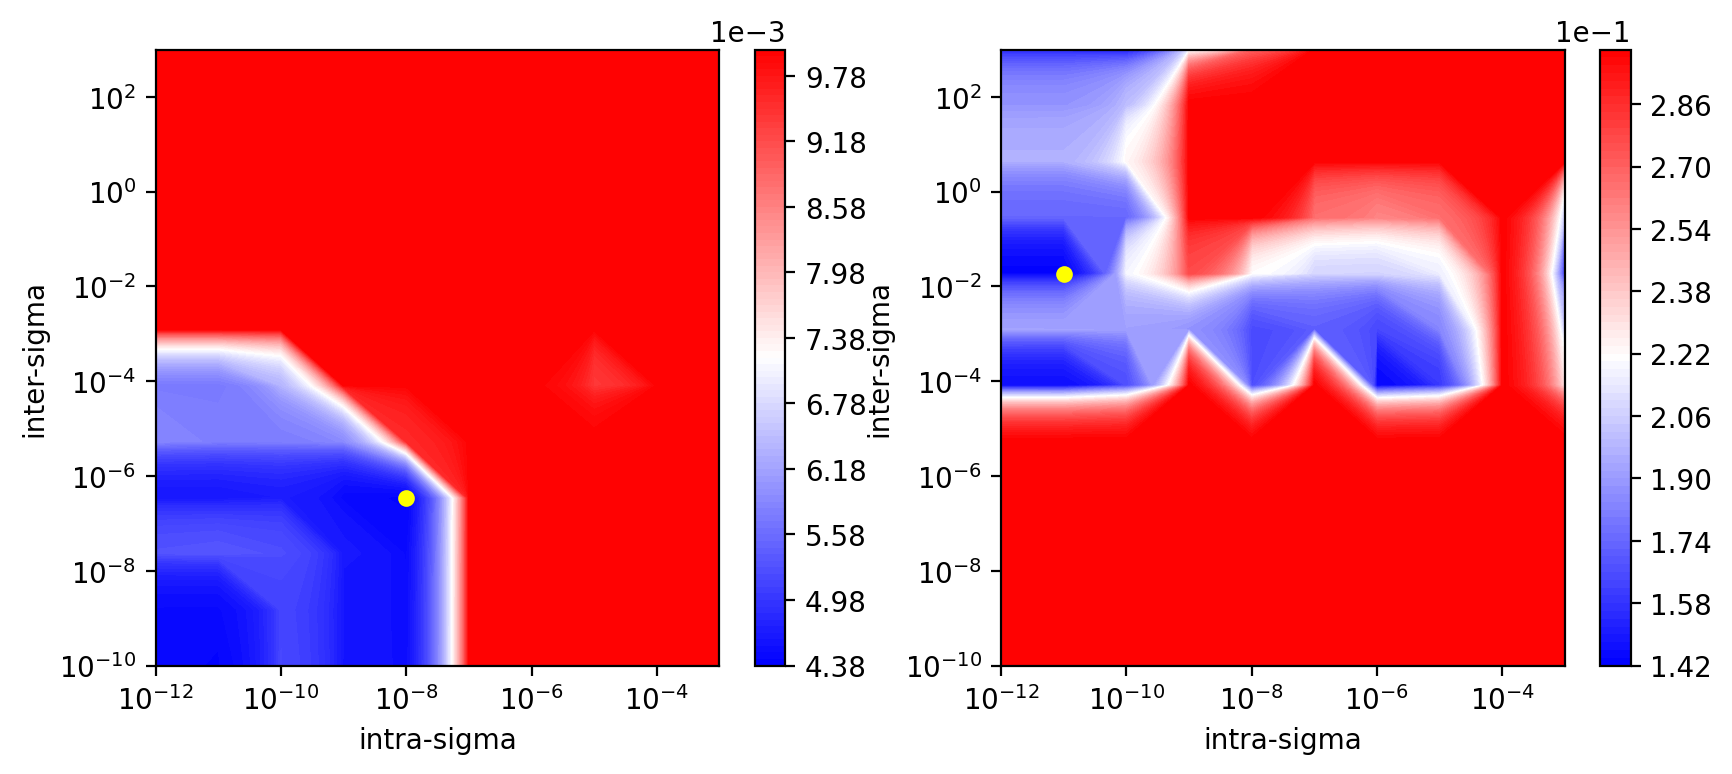

In [14]:
set_trn = liq_set_trn+sml_set_trn
eng_trn = np.hstack([liq_dft_trn, sml_dft_trn])
L = np.diag([1]*len(liq_set_trn)+[-1]*len(sml_set_trn))+np.diag([1]*len(sml_set_trn),-len(liq_set_trn))
intra_sig_col = np.geomspace(1.e-12, 1.e-3, num=10)
inter_sig_col = np.geomspace(1.e-10, 1.e+3, num=12)
intra_rmse_col, inter_rmse_col = scan_regularization_2D(set_trn, eng_trn, intra_sig_col, inter_sig_col, L)
idx = plot_regularization_2D(intra_sig_col, inter_sig_col, intra_rmse_col, inter_rmse_col)

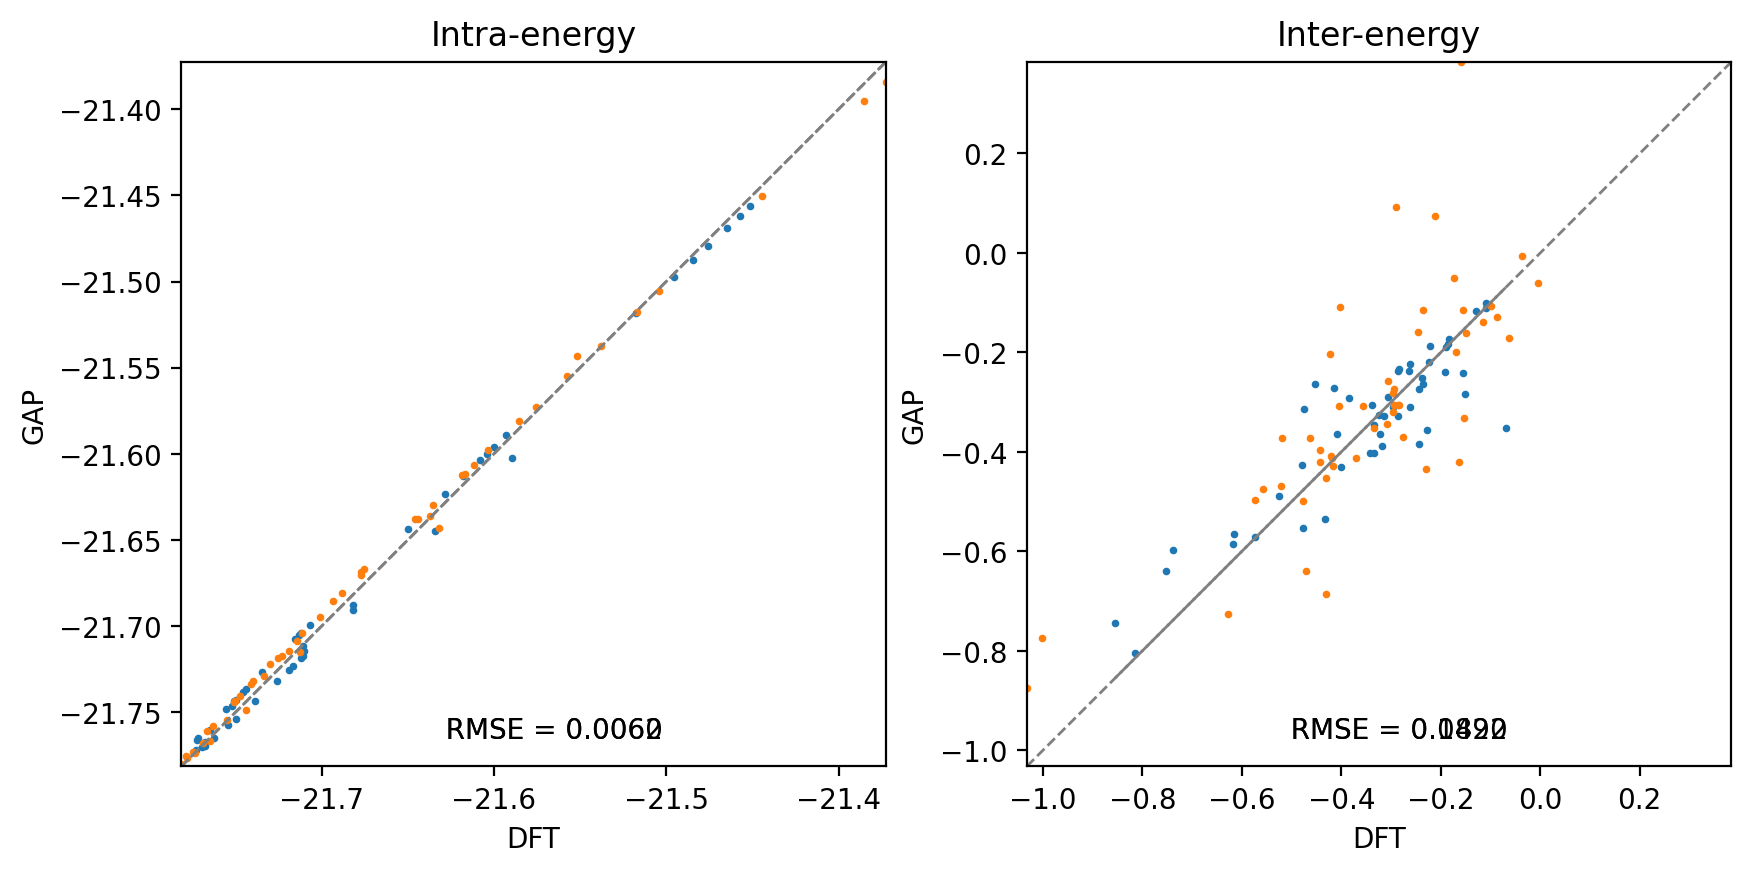

In [15]:
intra_sig = 1e-12#intra_sig_col[idx[0]]
inter_sig = 1e-4#inter_sig_col[idx[1]]
L = np.diag([1]*len(liq_set_trn)+[-1]*len(sml_set_trn))+np.diag([1]*len(sml_set_trn),-len(liq_set_trn))
S = np.matmul(np.linalg.inv(L), np.diag([inter_sig]*len(liq_set_trn)+[intra_sig]*len(sml_set_trn)))
c = train_model(set_trn, eng_trn, S)
plot_intra_inter(set_trn, c)